In [1]:
using AutoRisk
using AutoViz
using CommandLineFlags
using Interact
using Reel
Reel.set_output_type("gif");
include("create_artificial_dataset.jl");

In [2]:
col = build_dataset_collector("");

In [3]:
function Base.show(col::DatasetCollector, seed::Int; target_idx::Int = 1)
    if target_idx <= size(col.eval.targets, 1)
        # this is labeled collisions, but can be any target, selected by target_idx
        in_collision_veh_idxs = find(sum(col.eval.agg_targets[target_idx,:], 2) .> 0.)
    else
        in_collision_veh_idxs = []
    end
    
    # if no collisions then still display the scene, but change car colors
    collisions_exist = in_collision_veh_idxs == [] ? false : true
    collision_color = collisions_exist ? colorant"red" : colorant"orange"
    if !collisions_exist
        in_collision_veh_idxs = sort(collect(values(col.eval.veh_id_to_idx)))
    end
    
    # prepare film for save case
    frames = Frames(MIME("image/png"), fps=10)
    
    # display the record
    @manipulate for follow_veh_idx in in_collision_veh_idxs,
                zoom in collect(1.:2:20.),
                i in 1:(col.eval.rec.nframes),
                save in [false, true],
                clear in [false, true]
        
        i -= 1
        # set camera
        follow_veh_id = -1
        if follow_veh_idx == 0
            cam = FitToContentCamera()
        else
            for (veh_id, veh_idx) in col.eval.veh_id_to_idx
                if veh_idx == follow_veh_idx
                    follow_veh_id = veh_id
                    break
                end
            end
            cam = AutoViz.CarFollowCamera{Int}(follow_veh_id, zoom)
        end

        # render scene
        idx = -(col.eval.rec.nframes - i) + 1
        carcolors = Dict{Int,Colorant}()
        for veh in col.eval.rec[idx]
            # carcolors[veh.id] = veh.id == follow_veh_id ? collision_color : colorant"green"
            
            if col.models[veh.id].mlon.v_des > 30.
                carcolors[veh.id] = colorant"red"
            else
                carcolors[veh.id] = colorant"blue"
            end
                

        end
        mlane = 0
        if typeof(col.models[follow_veh_id]) == DelayedDriver
            mlane = col.models[follow_veh_id].driver.mlane
        elseif typeof(col.models[follow_veh_id]) == Tim2DDriver
            mlane = col.models[follow_veh_id].mlane
        else
            mlane = nothing
        end
        
        stats = follow_veh_id == -1 ? [] : [
            CarFollowingStatsOverlay(follow_veh_id, 2), 
            NeighborsOverlay(follow_veh_id, textparams = TextParams(x = 600, y_start=300))]
        
        frame = render(col.eval.rec[idx], col.roadway, stats,
            cam = cam, car_colors = carcolors)
        push!(frames, frame)
        
        # to use the save, move around the slider above and collect some frames to write
        # then switch to save, then switch off save
        # this will write the frames, and then clear them
        if save
            filename = "seed_$(seed)_veh_id_$(follow_veh_idx)_target_$(target_idx)"
            write("../../data/visualizations/outputs/$(filename).gif", frames)
            frames = Frames(MIME("image/png"), fps=2)
        end
        
        # to clear frames without saving them set this to true then false
        if clear
            frames = Frames(MIME("image/png"), fps=10)
        end
        
        frame
    end

end

In [4]:
seed = 1
rand!(col, seed)
evaluate!(col.eval, col.scene, col.models, col.roadway, seed);

Interact.Options{:ToggleButtons,Int64}(1: "input" = 1 Int64 ,"follow_veh_idx",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",30=>"30",2=>"2",16=>"16",11=>"11",21=>"21",7=>"7",9=>"9",25=>"25",10=>"10"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(3: "input-2" = 1.0 Float64 ,"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(5: "input-3" = 426 Int64 ,"i",426,"426",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(306=>"306",29=>"29",74=>"74",176=>"176",285=>"285",318=>"318",354=>"354",610=>"610",563=>"563",671=>"671"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(7: "input-4" = false Bool ,"save",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(9: "input-5" = false Bool ,"clear",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

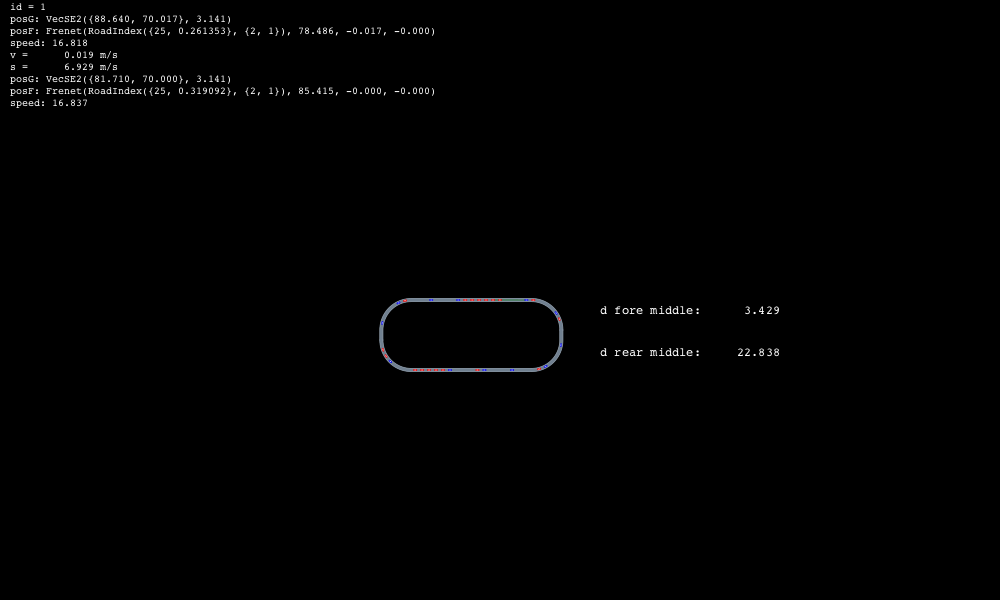

In [5]:
show(col, seed, target_idx = 6)